In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Load dataset
df = pd.read_csv("tea_forex.csv", parse_dates=["Year-Month"], index_col="Year-Month")

In [4]:
df.head()

,High_Grown_Production_(Kg),Mid_Grown_Production_(Kg),Low_Grown_Production_(Kg),National_Production_(Kg),FEE_(Million_USD)
Year-Month,,,,,
2012-01-01,5361185.05,3652353.15,14348315.90,23361854.10,95.32
2012-02-01,5538399.31,3955745.75,13133213.00,22627358.06,100.17
2012-03-01,6385525.09,4625138.90,17929328.00,28939991.99,130.31
2012-04-01,7323011.00,5748401.20,16982493.50,30053905.70,110.41
2012-05-01,8726319.70,5898297.10,18086627.25,32711244.05,149.19


In [5]:
# Select only the column needed for forecasting
prod_data = df[["National_Production_(Kg)"]].copy()

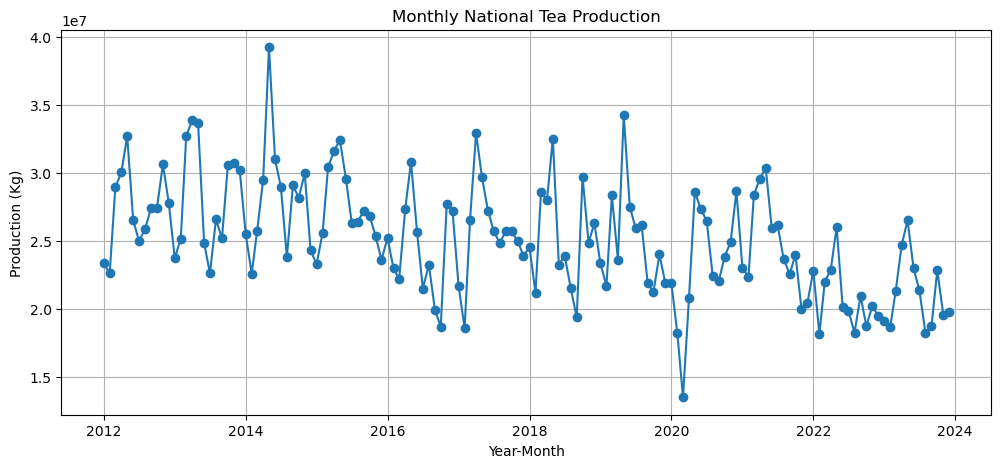

In [6]:
# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(prod_data, marker='o', linestyle='-')
plt.title("Monthly National Tea Production")
plt.xlabel("Year-Month")
plt.ylabel("Production (Kg)")
plt.grid()
plt.show()

In [7]:
# 1. Augmented Dickey-Fuller (ADF) Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("Series is stationary.")
    else:
        print("Series is NOT stationary.")

In [8]:
print("ADF Test Before Differencing:")
adf_test(prod_data["National_Production_(Kg)"])

ADF Test Before Differencing:
ADF Statistic: -0.894501201586031
p-value: 0.7897778567663785
Critical Values: {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}
Series is NOT stationary.


In [10]:
from scipy.stats import skew

print("Skewness before Box-Cox:", skew(prod_data["National_Production_(Kg)"]))
# If skewness is between -1 and 1, transformation isn’t needed.

Skewness before Box-Cox: 0.29146981921421766


In [12]:
# 3. First Differencing
prod_data["Prod_Diff"] = prod_data["National_Production_(Kg)"].diff().dropna()

In [13]:
print("ADF Test After First Differencing:")
adf_test(prod_data["Prod_Diff"].dropna())

ADF Test After First Differencing:
ADF Statistic: -6.966933408278948
p-value: 8.86545571015707e-10
Critical Values: {'1%': -3.4808880719210005, '5%': -2.8836966192225284, '10%': -2.5785857598714417}
Series is stationary.


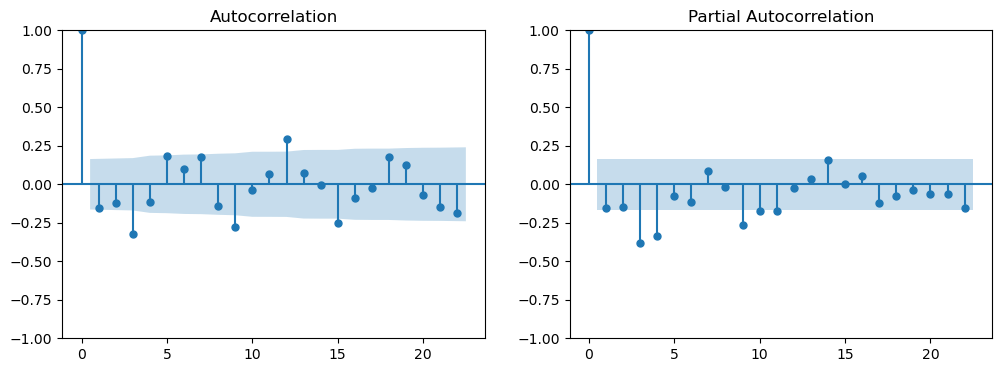

In [14]:
# 4. ACF & PACF Plots to determine ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(prod_data["Prod_Diff"].dropna(), ax=axes[0])
plot_pacf(prod_data["Prod_Diff"].dropna(), ax=axes[1])
plt.show()

In [16]:
# 5. Split data into train and test sets
train_size = int(len(prod_data) * 0.8)
train, test = prod_data["National_Production_(Kg)"][:train_size], prod_data["National_Production_(Kg)"][train_size:]

In [17]:
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3786.746, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3798.201, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3798.248, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3797.844, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3796.209, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3784.569, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3782.015, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3789.606, Time=0.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3785.913, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3799.656, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3786.035, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3787.273, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3

In [74]:
# 6. Train ARIMA Model
p, d, q = 9, 1, 12  # Adjust based on ACF & PACF
model = ARIMA(train, order=(p, d, q))
arima_model = model.fit()

In [75]:
# Print Model Summary
# print(arima_model.summary())

In [76]:
# 7. Forecast future values
forecast = arima_model.forecast(steps=len(test))

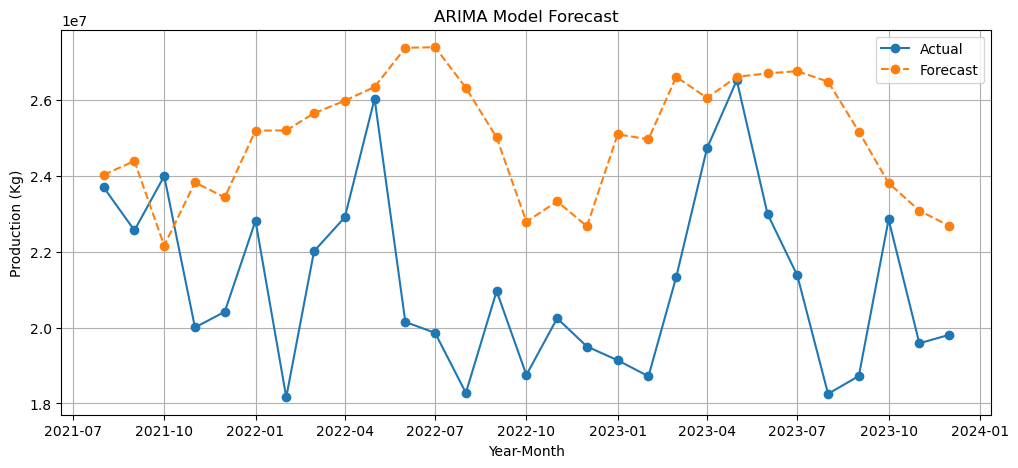

In [77]:
# 8. Plot Actual vs. Forecast
plt.figure(figsize=(12, 5))
plt.plot(prod_data.index[train_size:], test, label="Actual", marker="o")
plt.plot(prod_data.index[train_size:], forecast, label="Forecast", marker="o", linestyle="dashed")
plt.title("ARIMA Model Forecast")
plt.xlabel("Year-Month")
plt.ylabel("Production (Kg)")
plt.legend()
plt.grid()
plt.show()

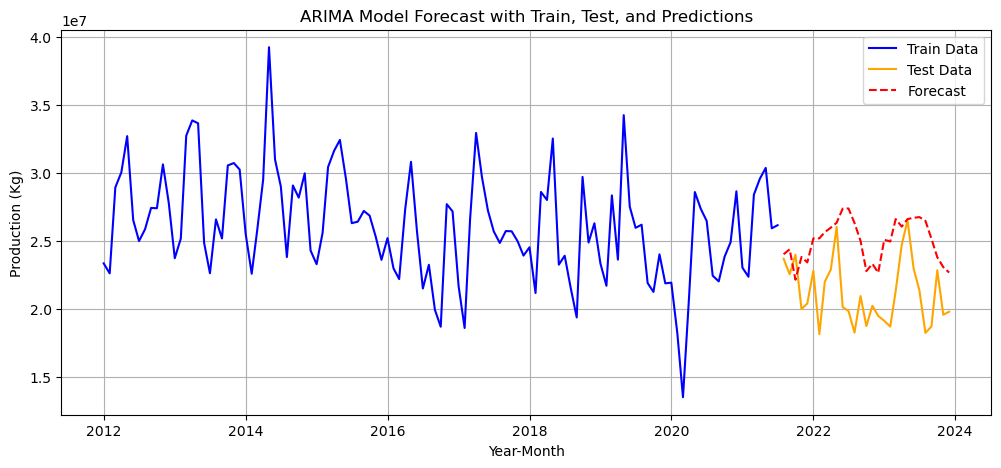

In [78]:
# Plot Actual vs. Forecast, including train and test data
plt.figure(figsize=(12, 5))
plt.plot(prod_data.index[:train_size], train, label="Train Data", color="blue")
plt.plot(prod_data.index[train_size:], test, label="Test Data", color="orange")
plt.plot(prod_data.index[train_size:], forecast, label="Forecast", color="red", linestyle="dashed")
plt.title("ARIMA Model Forecast with Train, Test, and Predictions")
plt.xlabel("Year-Month")
plt.ylabel("Production (Kg)")
plt.legend()
plt.grid()
plt.show()

In [79]:
# Model Evaluation
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

In [80]:
print(f"\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.4f}")
print(f"Akaike Information Criterion (AIC): {arima_model.aic:.4f}")


Model Evaluation Metrics:
Mean Squared Error (MSE): 21125892289089.2266
Root Mean Squared Error (RMSE): 4596291.1449
Mean Absolute Percentage Error (MAPE): 19.7974
Akaike Information Criterion (AIC): 3790.0225


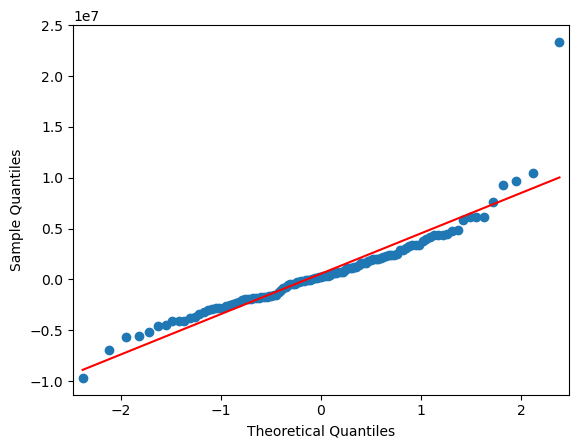

In [81]:
import statsmodels.api as sm
residuals = arima_model.resid
sm.qqplot(residuals, line='s')
plt.show()
# If residuals deviate significantly from normality, more tuning is needed.

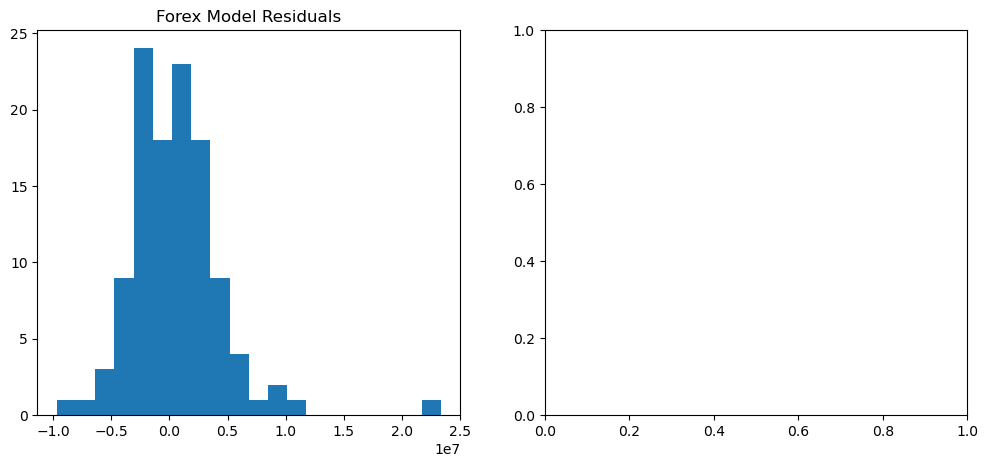

In [82]:
# Residual Analysis
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(arima_model.resid, bins=20)
plt.title("Forex Model Residuals")
plt.subplot(1,2,2)
plt.show()